In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import save_image


import math
import random
import numpy as np
import os
import argparse
import matplotlib.pyplot as plt

In [2]:
seed = 0
random.seed(seed)
torch.manual_seed(seed)

In [3]:
# parameter
parser = argparse.ArgumentParser(description='HyperParameters of DCGAN')
parser.add_argument("--n_epochs", type=int, default=100, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=32, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=400, help="interval betwen image samples")

args = parser.parse_args('')
print(args)

Namespace(n_epochs=100, batch_size=64, lr=0.0002, b1=0.5, b2=0.999, n_cpu=8, latent_dim=100, img_size=32, channels=1, sample_interval=400)


In [4]:
dataloader = DataLoader(
  dset.MNIST(
    '../data/mnist',
    train=True,
    download=False,
    transform=transforms.Compose(
      [transforms.Resize(args.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
    )
  ),
  batch_size=args.batch_size,
  shuffle=True
)

# USE_CUDA
USE_CUDA = True if torch.cuda.is_available() else False
DEVICE = torch.device("cuda:0" if USE_CUDA else "cpu")

In [5]:
def weights_init_normal(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm2d') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
    nn.init.constant_(m.bias.data, 0.0)

In [6]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    def block(input_dim, ouput_dim, kernel_size, stride, padding):
      layers=[
        nn.ConvTranspose2d(input_dim, ouput_dim, kernel_size, stride, padding, bias=False),
        nn.BatchNorm2d(ouput_dim),
        nn.ReLU(inplace=True)
      ]
      
      return layers

    self.model = nn.Sequential(
      # B x 100 x 1 x 1
      *block(args.latent_dim, 128, 4, 1, 0),
      # B x 512 x 4 x 4
      *block(128, 64, 4, 2, 1),
      # B x 256 x 8 x 8
      *block(64, 32, 4, 2, 1),
      # B x 128 x 16 x 16
      nn.ConvTranspose2d(32, args.channels, 4, 2, 1, bias=False),
      # B x 1 x 32 x 32
      nn.Tanh()
    )

  def forward(self, z):
    return self.model(z)

In [7]:
netG = Generator().to(DEVICE)
netG.apply(weights_init_normal)
print(netG)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


In [8]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    def block(input_dim, ouput_dim, kernel_size, stride, padding):
      layers=[
        nn.Conv2d(input_dim, ouput_dim, kernel_size, stride, padding, bias=False),
        nn.BatchNorm2d(ouput_dim),
        nn.LeakyReLU(0.2, inplace=True)
      ]
      
      return layers


    self.model = nn.Sequential(
      # B x 1 x 32 x 32
      nn.Conv2d(args.channels, 32, 4, 2, 1, bias=False),
      nn.LeakyReLU(0.2, inplace=True),
      # B x 32 x 16 x 16
      *block(32, 64, 4, 2, 1),
      # B x 64 x 8 x 8
      *block(64, 128, 4, 2, 1),
      # B x 128 x 4 x 4
      nn.Conv2d(128, 1, 4, 1, 0, bias=False),
      # B x 1 x 1 x 1
      nn.Sigmoid()
    )

  def forward(self, img):
    return self.model(img)

In [9]:
netD = Discriminator().to(DEVICE)
netD.apply(weights_init_normal)
print(netD)

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


In [10]:
criterion = nn.BCELoss()

optimizer_D = optim.Adam(netD.parameters(), lr=args.lr, betas=(args.b1, args.b2))
optimizer_G = optim.Adam(netG.parameters(), lr=args.lr, betas=(args.b1, args.b2))

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

In [11]:
img_list = []
G_losses = []
D_losses = []

real_label = 1.0
fake_label = 0.0

for epoch in range(args.n_epochs):
  for idx, (imgs, _) in enumerate(dataloader):
    
    # 이미지 타입 변경
    imgs = imgs.to(DEVICE)
    
    # 레이블 생성
    # args.batch_size가 아닌 dataloader에서 받은 size사용해야함 
    label = torch.full((imgs.size(0),), real_label, dtype=torch.float, device=DEVICE)

    ###
    # D network : maximize log(D(x)) + log(1 - D(G(z)))
    ###
    netD.zero_grad()

    # 실제 이미지 loss : D(x)
    output = netD(imgs).view(-1)
    real_loss = criterion(output, label)
    real_loss.backward()
    D_x = output.mean().item()

    # 생성 이미지 loss : 1-G(D(z))
    z = torch.randn(imgs.size(0), args.latent_dim, 1, 1, device=DEVICE)
    fake_img = netG(z)
    label.fill_(fake_label)
    output = netD(fake_img.detach()).view(-1)
    fake_loss = criterion(output, label)
    fake_loss.backward()
    D_G_z1 = output.mean().item()

    D_loss = real_loss + fake_loss
    optimizer_D.step()

    ###
    # G network : maximize log(D(G(z)))
    ###

    netG.zero_grad()
    label.fill_(real_label)
    output = netD(fake_img).view(-1)
    G_loss = criterion(output, label)
    G_loss.backward()
    D_G_z2 = output.mean().item()
    optimizer_G.step()


    G_losses.append(G_loss.item())
    D_losses.append(D_loss.item())

    batches_done = epoch * len(dataloader) + idx
    if batches_done % args.sample_interval == 0:
      save_image(fake_img.data[:25], "DCGAN_img/%d.png" % batches_done, nrow=5, normalize=True)
  
  print(f'[EPOCH {epoch}/{args.n_epochs}] [D loss: {D_loss.item():.2f}] [G loss: {G_loss.item():.2f}]')

[EPOCH 0/100] [D loss: 0.58] [G loss: 3.06]
[EPOCH 1/100] [D loss: 0.36] [G loss: 1.93]
[EPOCH 2/100] [D loss: 0.43] [G loss: 2.65]
[EPOCH 3/100] [D loss: 0.33] [G loss: 2.44]
[EPOCH 4/100] [D loss: 0.53] [G loss: 4.25]
[EPOCH 5/100] [D loss: 0.13] [G loss: 3.29]
[EPOCH 6/100] [D loss: 0.39] [G loss: 2.31]
[EPOCH 7/100] [D loss: 0.64] [G loss: 2.37]
[EPOCH 8/100] [D loss: 0.27] [G loss: 4.76]
[EPOCH 9/100] [D loss: 0.32] [G loss: 2.41]
[EPOCH 10/100] [D loss: 0.07] [G loss: 4.26]
[EPOCH 11/100] [D loss: 1.30] [G loss: 0.99]
[EPOCH 12/100] [D loss: 0.07] [G loss: 4.55]
[EPOCH 13/100] [D loss: 0.01] [G loss: 6.56]
[EPOCH 14/100] [D loss: 0.00] [G loss: 6.87]
[EPOCH 15/100] [D loss: 0.00] [G loss: 8.15]
[EPOCH 16/100] [D loss: 0.07] [G loss: 4.87]
[EPOCH 17/100] [D loss: 0.00] [G loss: 6.66]
[EPOCH 18/100] [D loss: 0.02] [G loss: 6.79]
[EPOCH 19/100] [D loss: 0.12] [G loss: 3.63]
[EPOCH 20/100] [D loss: 0.07] [G loss: 4.35]
[EPOCH 21/100] [D loss: 0.01] [G loss: 7.90]
[EPOCH 22/100] [D lo

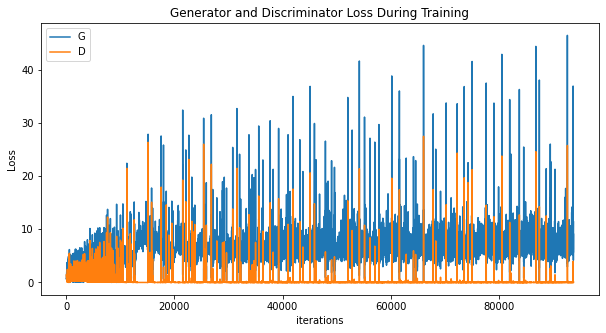

In [12]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

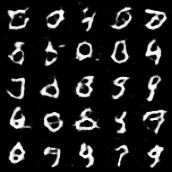

In [13]:
from IPython.display import Image
Image('./DCGAN_img/2000.png')

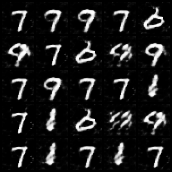

In [14]:
Image('./DCGAN_img/89600.png')